In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
np.seterr(divide='ignore');

In [2]:
N_fft = 256
fs = 2000
Rb = 250/32

In [3]:
def lrtc_ber_sim(ebn0_dB, n_sims = 100000):
    ebn0 = 10**(0.1*ebn0_dB)
    snr = ebn0 * Rb * N_fft/ fs
    noise = np.random.randn(n_sims, N_fft) + 1j * np.random.randn(n_sims, N_fft)
    noise[:,0] += 2*snr # the factor 2 is because since the noise is complex, it has power 2
    # the following is a simple way to count bit errors
    # it works because the FFT bin number 0 is the one in which the signal is
    # present, while the remaining bins are interchangeable
    return np.average(np.argmax(np.abs(noise), axis = 1) % 2)

def lrtc_ber_formula(ebn0_dB):
    ebn0 = 10**(0.1*ebn0_dB)
    cnr = ebn0 * Rb / fs * N_fft+1;
    return 0.5*(1-chi2.cdf(cnr, 2)**N_fft)

In [4]:
ebn0s = np.linspace(-2, 8, 20)
bers_sim = np.array([lrtc_ber_sim(ebn0) for ebn0 in ebn0s])

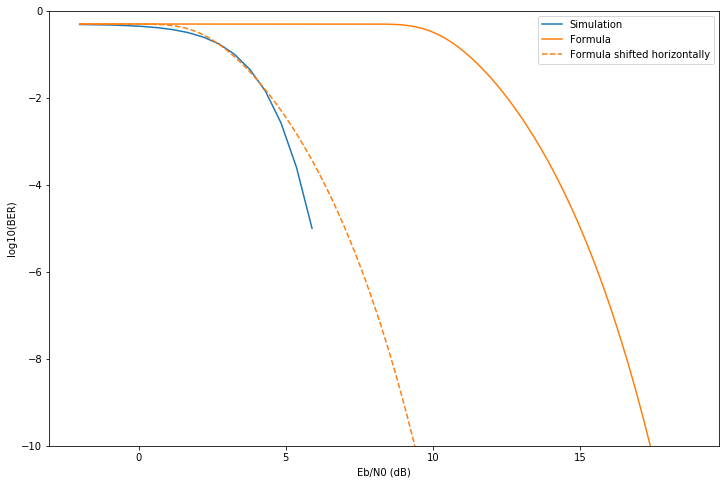

In [5]:
plt.figure(figsize = (12, 8), facecolor = 'w')
ebn0s_formula = np.linspace(-2, 20, 1000)
plt.plot(ebn0s, np.log10(bers_sim))
plt.plot(ebn0s_formula, np.log10(lrtc_ber_formula(ebn0s_formula)))
plt.plot(ebn0s_formula, np.log10(lrtc_ber_formula(ebn0s_formula+8)), color = 'C1', linestyle = '--')
plt.legend(['Simulation', 'Formula', 'Formula shifted horizontally'])
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('log10(BER)')
plt.ylim([-10,0]);